### Self attention for a single individual head

In [37]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [38]:
# version 4 : self attention
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # 4 x 8 arrangement of tokens and each token has a information which is 32 dimensional embedded inside
x = torch.randn(B, T,C ) # currently working with just random numbers

In early cases, we will be doing a simple average and we dont actually want this to be all uniform because different tokens will find different other tokens more or less interesting and we want that to be data dependent so for example, if I am a vowel then maybe we must look for consonants in my past and maybe i want to know what that those consonants are and I want the information to flow to me but I want to now gather info from the past, but in a way its data dependent and this is the problem that the self attention solves.

The way it solves is, every single node or every single token at each position will emit 2 vectors and it will emit a query and it will emit a key, now the query vector roughly speaking is what i am looking for and the key vector roughly speaking is what do i contain and then the way we get the affinities between these tokens now in a sequence is we basically just do a product between keys and queries so my query dot products with all the keys of all the other tokens and the dot product now becomes wei  and so, if key and query are sort of aligned they will interact to very high amount and then i will get to learn more about specific token as opposed to any other token in the sequence, so lets implement this now and we are going to implement a single whats called head of self attention

In [35]:
# lets see a single head perform self attention
head_size = 16  # hyper parameter
key = nn.Linear(C, head_size, bias= False) # matrix multiple with some fixed weights
query = nn.Linear(C, head_size, bias= False)

k = key(x) # (B, T, 16)
q = query(x) # (B, T, 16)
# produce k and q by forwarding these modules on X, 
# all the tokens in all the positions in the B X T arrangement, all of them in parallel and independently produce a key and a query
# no communication has happened yet but it comes now

# all the queries will now get dot product with keys
wei =  q @ k.transpose(-2, -1) # for it to be matrix multiplied, we need to keep the B as it is and then trnaspose the last 2 dimensions
# (B, T,16) @ (B, 16, T) -------->  (B, T, T)
print(wei[0])
# for every row of B, we are now going to have a T square matrix giving us the affinities.
# therefore these are not zero and they are resulted as a value after their communication 

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf')) # all elements where tril is 0, we get -inf
# version 3: use softmax 
wei = F.softmax(wei, dim = -1) # softmax over every single row, 
# softmax is also a normalisation operation and we get the exact same matrix
out = wei @ x
print(out.shape)

tensor([[-1.7629, -1.3011,  0.5652,  2.1616, -1.0674,  1.9632,  1.0765, -0.4530],
        [-3.3334, -1.6556,  0.1040,  3.3782, -2.1825,  1.0415, -0.0557,  0.2927],
        [-1.0226, -1.2606,  0.0762, -0.3813, -0.9843, -1.4303,  0.0749, -0.9547],
        [ 0.7836, -0.8014, -0.3368, -0.8496, -0.5602, -1.1701, -1.2927, -1.0260],
        [-1.2566,  0.0187, -0.7880, -1.3204,  2.0363,  0.8638,  0.3719,  0.9258],
        [-0.3126,  2.4152, -0.1106, -0.9931,  3.3449, -2.5229,  1.4187,  1.2196],
        [ 1.0876,  1.9652, -0.2621, -0.3158,  0.6091,  1.2616, -0.5484,  0.8048],
        [-1.8044, -0.4126, -0.8306,  0.5898, -0.7987, -0.5856,  0.6433,  0.6303]],
       grad_fn=<SelectBackward0>)
torch.Size([4, 8, 32])


The weighted aggregation now is a function in a data dependent manner between the keys and queries of these nodes

In [23]:
wei
# earlier wei was just constatnt, but now every single batch element will have different sort of wei
# every single batch element contains different tokens at different positions and so this is not data dependent 


tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

In [24]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

[0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391] knows what content it has and it knows at what position it is in and now the 8th token based on that creates a query : hey I am looking for this kind of stuff, I am a vowel and on the 8th position and I am looking for any consonants at positions upto 4 
<br><br>
and then all the nodes get to emit keys and maybe one of the channels could be I am a consonant and I am in a position upto 4 and that key would have a high number in that specific channel and thats how the query and the key when they dot product they can find each other and creates a high affinity and when they have high affinity like say this token was pretty interesting to this eight token when they have high affinity
<br><br>
and then through softmax, I will end up aggregating a lot of its info into my position and so I will get to learn a lot about it

Without the masking and the softmax, wei comes out like the outputs of the dot products and these are raw outputs and they taken on values from -2 to +2 etc. so thats the raw interactions and raw affinities between all the nodes.
<br><br>
Y masking: Obviously if I am a fifth node, then I would not want to aggregate anything from 6th or 7th or 8th node, so we end up masking the upper triangular area and so those are not allowed to communicate
<br><br>
Y softmax : To get a nice distribution, to aggregating negative of this node, we exponentiate and normalise and we get a distribution that sums to 1 and this is telling us now in the data dependent manner how much of info to aggregate from any of these tokens in the past and not zeros as previous calculation

In [33]:

head_size = 16  
key = nn.Linear(C, head_size, bias= False) 
query = nn.Linear(C, head_size, bias= False)
value = nn.Linear(C, head_size, bias= False)

k = key(x) 
q = query(x) 

wei =  q @ k.transpose(-2, -1) 

print(wei[0])

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf')) 

wei = F.softmax(wei, dim = -1) 

v = value(x) 
out = wei @ v
print(out.shape) # output will be 16 dim because that is the head sizeand so u can think of x as private info to this token
# x is the info of the fifth token at som position and I have some identity and my info is kept in x and now for the purposes of single head, I am interested in is what I have and if you find me interesting and I will communicate to you and thats stored in v.
# so v is the thing that gets aggregated for the purposes of this single head between the different nodes and self attention mechanism

tensor([[-1.1915e+00, -1.1196e-01,  5.9079e-01,  3.6801e-01, -1.3106e+00,
          4.3066e-01,  5.8015e-01, -2.1989e-01],
        [-3.3711e-01,  3.4888e+00, -1.9695e+00,  3.3830e-01,  5.3988e+00,
          7.9434e-03,  9.7835e-01,  1.0659e+00],
        [ 2.4687e+00,  3.3016e+00,  3.9965e-01, -3.3672e-01,  3.2398e-01,
          2.1113e+00, -2.6735e-01,  3.7084e-01],
        [ 1.9890e+00, -1.6711e+00, -1.3341e+00, -1.0760e+00,  6.1292e-01,
          1.2301e+00, -2.2057e+00, -8.6696e-01],
        [-3.7363e-02,  9.3738e-01,  1.0745e+00,  1.3520e+00, -5.7113e-02,
         -2.2037e+00,  2.5697e-01,  1.8758e+00],
        [-7.9295e-01, -1.9818e+00,  1.1721e+00, -4.1350e-01,  1.6827e+00,
         -8.6104e-02, -4.3308e-01,  1.1520e+00],
        [-8.6515e-01, -3.7796e-01, -1.5812e+00,  1.9181e+00, -4.6045e-01,
          2.0966e+00, -8.0967e-01, -2.6921e-01],
        [ 3.7686e-02,  5.3952e-01,  4.7238e-01,  1.1007e+00,  3.5744e-01,
         -1.0245e+00,  2.3461e-03,  1.6056e+00]], grad_fn=<Select

Notes:

- Attention is a communication mechanism where you have number of nodes in a directed graph where the edges will be pointed between nodes like this

    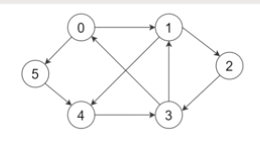

and every node has some vector of information and it gets to aggregate information via a weighted sum from all of the nodes that points to it and this is done in a data dependent manner so depending on whatever data is actually stored at any point in time.

<br>
Our graph doesn't look like this, we have 8 nodes because block_size is 8 and then there is always 8 tokens and the first node is only pointed to itself  and second node will be pointed by the first node and to itself all the way upto 8th node which will pointed to by all the previous nodes and itself and so thats the structure that our directed graph has or happens to have in an auto regressive sort of scenario like language modelling but in principle attention can be applied to any arbitrary directed graph and its just a communication mechanism between nodes

- There is no notion of space so attention simply acts over like a set of vectors in this graph and so by default, these nodes have no idea were they are positioned in the space and thats why we need to encode them positionally and sort of give them info that is anchored to a specific position so they sort of know where they are and this is different than for example from convolution because if you run a convolution operation over some input there is very specific sort of layout of the information in space and the convolution filters sort of act in space and so its not like an attention. In attention, its just a set of vectors out there in space they communicate and if you want them to have a notion of space, you need to specifically add it which is what we have done when we calculated the relative the positional encode encodings and added info to the vectors.

- elements across the bacth dimension which are independent examples, never talk to each other. They are always processed independently and this is a batched matrix multiply that applies basically a matrix multiplication kind of in parallel across the batch dimension 

    wei =  q @ k.transpose(-2, -1) 

    so maybe it would be more acccurate to say that in this analogy of the directed graph because batch size is 4 we really have 4 separate pools of 8 nodes and those 8 nodes only talk to each other but in total there is like 32 nodes that are being processed but there is sort of 4 separated pools of 8 

- We have a specific structure of directed graph where the future tokens will not communicate to the past tokens but this doesn't necessarily have to be the constraint in the general case and in fact in many cases, you want to have all of the nodes talk to each other fully, so as an example, if you are doing sentimental analysis or something like that with a transformer you might have a number of tokens and you may want to have them all talk  to each other fully because later you are predicting for a sentiment of the sentence so its okay for these nodes to talk to each other and so in these cases, you will use an encoder block of self attention adn all it means that its an encoder block is that you will delete this line of code $ wei = wei.masked_fill(tril == 0, float('-inf')) $  allowing all the nodes to completely talk to each other what we are implementing here is sometimes called decoder block and its called decoder because its sort of like decoding language and its got this auto regressive format where you have to mask with the triangular matrix so that nodes from the future never talk to the past because they would give away the answer and so basically in encoder blocks you would delete this $ wei = wei.masked_fill(tril == 0, float('-inf')) $ allow all the nodes to talk and in decoder blocks this $ wei = wei.masked_fill(tril == 0, float('-inf')) $ will always be present so that u have this triangular structure but both are allowed and attention doesn't care, attention supports arbitrary connectivity between nodes.

- Reason the attention we found is self attention is because the keys and queries and the values are all coming from the same source (from x) so the same source x produce keys queries and values so these nodes are self attending but in principle attention is much more general than that.

    For example, an encoder decoder transformers can have a case where the queries are produced from x but keys and values come from a whole separate external source and sometimes from encoder blocks that encode some context that we would like to condition on and so the keys and values will actually come from a whole separate source those are nodes on the side and here we are just producing queries and we are reading off info from the side so cross attention is used when there is separate source of nodes we would like to pull info from into our nodes and its self attention if we just have nodes that would like to look at each other and talk to each other so this attention here happens to be self attention but in principle, attention is lot more general.

- When we look into the paper, we see 

    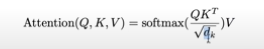

    where $ d_k $ is the head size.

    We have done everything but dividing by square root of head size is not done.
    They call this the scaled attention and its kind of like an important normalisation to basically have k nd q

    key = torch.randn(B, T, head_size) <br>
    query = torch.randn(B, T, head_size)

    the zero mean unit variance k and q are unit gaussian and then if we calculate wei naively, it will be the variance which will be on the order of head_size which in our case is 16 

In [47]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1)
k.var()
q.var()
wei.var()

tensor(13.6696)

In [48]:
k = torch.randn(B, T, head_size)
q= torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5 # multiply by 1/ square root of head size
# k.var()
# q.var() 
wei.var()

tensor(1.1445)

This will be one as it will be preserved. This is very important because wei will be fed into softmax and its really important especially at initialization that we be fairly diffuse, so in our case, we locked out here and $ wei $ had a fairly diffuse members so the problem is that because of softmax if weight takes on very positive and very negative numbers inside it softmax will actually converge towards one hot vectors

So we are applying softmax to a tensor of values that are very close to zero, then we are diffusing out of softmax.

In [49]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

but the moment I take the exact same thing and I start sharpening it making it bigger by multiplying these numbers by 8 for example, we will see that the softmax will start to sharpen and in fact it will sharpen towards the max, to whatever number here that is the highest

In [51]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1)

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

Basically we dont want these values to be too extreme especially at initialisation otherwise softmax will be way too peaky and we are basically aggregating information from like single node, every node just aggregates info from a single other node and thats not what we want especially at initialisation and so scaling is used just to control the variance at initialisation